In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import xarray as xr
import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hyperopt import fmin, hp, partial, tpe, Trials
import sys

sys.path.append('../..')
from pipeline.backtest import cross_validation
import pipeline.backtest_trading as bt

random_state = 42

base_ds = xr.open_dataset('../../data/nc_2round/base.nc')
fundamental_v0_ds = xr.open_dataset('../../data/nc_2round/fundamental_v0.nc')
market_ds = xr.open_dataset('../../data/nc_2round/market_brief.nc')

ds = xr.merge([base_ds, fundamental_v0_ds, market_ds])

In [3]:
## adding intraday feature
ds['volume_0'] = ds['volume'].sum(dim='timeslot')
ds['morning_volume_ratio'] = ds['volume'].isel(timeslot=slice(2)).sum(dim='timeslot') / ds['volume_0']
ds['tail_volume_ratio'] = ds['volume'].isel(timeslot=slice(-3, -1)).sum(dim='timeslot') / ds['volume_0']
ds['daily_volume_moving_3_ratio'] = ds['volume_0'] / ds['volume_0'].rolling(day=3).mean()
ds['daily_volume_moving_5_ratio'] = ds['volume_0'] / ds['volume_0'].rolling(day=5).mean()
ds['close_moving_5_ratio'] = ds['close_0'] / ds['close_0'].rolling(day=5).mean()
ds['close_moving_10_ratio'] = ds['close_0'] / ds['close_0'].rolling(day=10).mean()
ds['close_moving_20_ratio'] = ds['close_0'] / ds['close_0'].rolling(day=20).mean()

In [7]:
ds_price = ds['close'].stack({'bucket': ('day','timeslot')})

In [8]:
ds_price

<xarray.DataArray 'close' (asset: 54, bucket: 85000)>
array([[24.9557, 24.8465, 24.7008, ..., 35.0424, 35.1881, 35.1881],
       [16.3499, 16.3863, 16.362 , ..., 85.9128, 85.7307, 85.7307],
       [ 9.1763,  9.1399,  9.0914, ..., 83.4002, 83.3759, 83.2545],
       ...,
       [ 5.2315,  5.3286,  5.28  , ...,  9.9896,  9.9896,  9.9896],
       [ 8.3874,  8.3267,  8.3145, ..., 71.9541, 71.9055, 71.9662],
       [ 8.8972,  8.8486,  8.885 , ..., 16.0829, 16.1193, 16.1071]])
Coordinates:
  * asset     (asset) int32 0 1 2 3 4 5 6 7 8 9 ... 45 46 47 48 49 50 51 52 53
  * bucket    (bucket) object MultiIndex
  * day       (bucket) int32 1 1 1 1 1 1 1 ... 1700 1700 1700 1700 1700 1700
  * timeslot  (bucket) int32 1 2 3 4 5 6 7 8 9 10 ... 42 43 44 45 46 47 48 49 50

In [82]:
ds_price_ex = ds_price.isel(bucket=np.arange(5000,5100))

In [83]:
ds_price_ex

<xarray.DataArray 'close' (asset: 54, bucket: 100)>
array([[36.3654, 35.8921, 34.9696, ..., 37.4943, 37.47  , 37.47  ],
       [31.9472, 32.1657, 31.5467, ..., 34.4234, 34.3263, 34.5083],
       [19.1416, 19.0324, 18.3891, ..., 21.897 , 21.897 , 21.897 ],
       ...,
       [10.1595, 10.2687,  9.8318, ..., 10.3901, 10.463 , 10.463 ],
       [13.6067, 13.6067, 13.279 , ..., 14.9783, 15.039 , 15.1361],
       [13.5096, 13.4004, 12.927 , ..., 13.8737, 13.8495, 13.8616]])
Coordinates:
  * asset     (asset) int32 0 1 2 3 4 5 6 7 8 9 ... 45 46 47 48 49 50 51 52 53
  * bucket    (bucket) object MultiIndex
  * day       (bucket) int32 101 101 101 101 101 101 ... 102 102 102 102 102 102
  * timeslot  (bucket) int32 1 2 3 4 5 6 7 8 9 10 ... 42 43 44 45 46 47 48 49 50

In [84]:
price_ex_array = ds_price_ex.as_numpy()

## Let the PCA begin

In [85]:
from sklearn.decomposition import PCA
data = price_ex_array.T
data -= np.mean(data, axis=0) # centered
pca = PCA()
pca.fit(data)

PCA()

In [80]:
np.mean(data, axis=0)

<xarray.DataArray 'close' (asset: 54)>
array([-1.39799283e-15,  1.94688710e-15,  8.03801470e-16,  1.00630615e-15,
        1.49213975e-16,  1.73017156e-15,  3.35731443e-16, -2.03392858e-15,
       -5.29354338e-16, -4.52082816e-16, -8.97060204e-16, -2.40696352e-15,
       -3.27737837e-16,  2.87325719e-15, -8.52651283e-17, -1.39799283e-15,
       -7.58948460e-16,  2.88657986e-16, -1.32116540e-15,  1.46549439e-16,
        1.49658064e-16,  2.73736589e-15,  2.16715534e-16, -2.30571118e-15,
        6.67910172e-16, -1.36157752e-15,  8.79296636e-16,  6.09290396e-16,
        6.80522305e-15, -4.65405492e-15,  1.99662509e-15, -1.28341782e-15,
        8.99280650e-16,  5.17808019e-16, -1.06092912e-15,  1.97530881e-15,
       -1.06226139e-15, -7.46069873e-16,  1.13686838e-16, -2.15827356e-16,
        6.97220059e-16,  4.01900735e-16,  5.15143483e-16, -2.67164069e-15,
        2.25597319e-15, -9.54791801e-16,  3.80140364e-15,  1.29674049e-16,
        1.20436994e-15,  1.18838273e-15, -5.08926234e-16, -8.43769499e-17,
        6.15063556e-17,  6.82121026e-16])
Coordinates:
  * asset    (asset) int32 0 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52 53

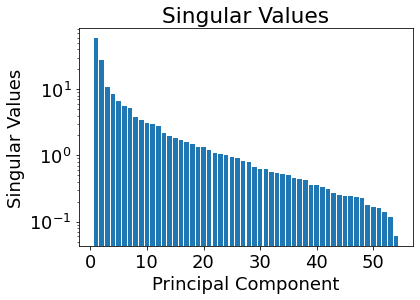

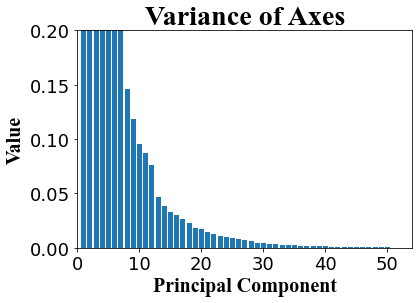

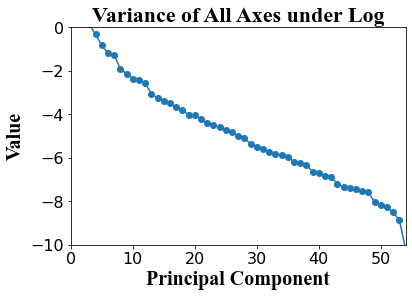

In [86]:
n_dim = np.array(data.shape).min()

plt.rcParams.update({'font.size': 18})
x_axis = np.array(range(n_dim))+1
plt.figure(0)
plt.bar(x_axis, pca.singular_values_, log = True)
plt.xlabel('Principal Component')
plt.ylabel('Singular Values')
plt.title('Singular Values')

plt.rcParams.update({'font.size': 18})
plt.figure(1)
plt.bar(x_axis, pca.explained_variance_)
plt.axis([0, x_axis.max(), 0, 0.2])
plt.xlabel('Principal Component', fontsize=20, fontname="Times New Roman", fontweight = 'bold')
plt.ylabel('Value', fontsize=20, fontname="Times New Roman", fontweight = 'bold')
plt.title('Variance of Axes', fontsize=28, fontname="Times New Roman", fontweight = 'bold')
plt.savefig('./PCA_total.png',bbox_inches='tight')



plt.rcParams.update({'font.size': 16})
plt.figure(2)
plt.plot(x_axis, np.log(pca.explained_variance_), 'o-')
plt.axis([0, x_axis.max(), -10, 0])
plt.xlabel('Principal Component', fontsize=20, fontname="Times New Roman", fontweight = 'bold')
plt.ylabel('Value', fontsize=20, fontname="Times New Roman", fontweight = 'bold')
plt.title('Variance of All Axes under Log', fontsize=22, fontname="Times New Roman", fontweight = 'bold')
plt.savefig('./PCA_total_log.png',bbox_inches='tight')

# cumsum = np.cumsum(pca.explained_variance_ratio_)
# print('the dimensions needed to capture {} of total variance is: {}'.format(thr, np.where(cumsum-thr>0)[0][0]))


In [87]:
pca.singular_values_[-1]

0.060741779154492914

In [88]:
eig_vec = pca.components_
np.linalg.norm(eig_vec, axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [89]:
kernel_eig_vec = eig_vec[-10:,:]
np.linalg.norm(kernel_eig_vec, axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [90]:
kernel_eig_vec

array([[ 8.56713543e-02, -2.67251815e-02, -9.48161716e-02,
        -2.06156688e-01,  1.26519375e-01,  4.91600579e-03,
        -1.41091988e-01,  3.58147169e-02, -1.90045815e-01,
        -1.61201338e-02, -5.09487521e-02, -5.29308257e-02,
         2.30766505e-01, -2.65943205e-03, -1.31982386e-01,
         7.95930508e-03, -1.48922844e-01,  2.64722631e-01,
        -1.28542099e-01,  3.67619601e-01, -5.72444102e-02,
        -3.05631393e-03,  2.57268983e-02, -1.41030434e-02,
        -8.89995355e-03,  8.20329931e-02,  1.30149441e-02,
        -1.06173861e-01,  5.21605832e-03,  3.75097146e-02,
        -4.62612438e-02, -1.23199804e-02, -2.30651057e-02,
         5.43419357e-01, -1.79572799e-01,  1.93287303e-02,
        -1.71430190e-05,  7.34272489e-02,  2.12144936e-01,
        -1.30208633e-01, -6.07631976e-02, -1.54700118e-01,
        -2.24663659e-02, -8.14006036e-02, -7.17086957e-03,
         7.19586091e-02, -1.77892962e-02, -2.41427678e-02,
         5.70187784e-02, -1.12843406e-01,  1.30636547e-0

In [93]:
np.sum(np.sum(kernel_eig_vec<0, axis=1)<0)

0

In [94]:
data.to_numpy()@kernel_eig_vec[9]

array([ 0.00247397,  0.00115402,  0.00103754, -0.0010227 , -0.00895785,
        0.0070211 ,  0.00777456, -0.0025034 ,  0.00742142, -0.00346203,
       -0.00232335, -0.00172405, -0.00644999,  0.00414408, -0.00077654,
        0.0029866 , -0.01225885,  0.00237009,  0.00247896, -0.00841875,
        0.0140772 ,  0.00369329, -0.00145974,  0.00062485, -0.00311767,
        0.01531393, -0.00338493,  0.00515123, -0.00949774, -0.01096693,
        0.00404088, -0.00543558,  0.00021715, -0.01050421,  0.01176664,
        0.00042597, -0.01056139,  0.00218104, -0.00410148,  0.01029171,
        0.00386035, -0.00093231, -0.00587991,  0.00675161, -0.00549633,
        0.00244559, -0.00519241,  0.00073706, -0.00268151,  0.00179852,
        0.00593247, -0.00418851, -0.00185066, -0.00665376,  0.00640879,
       -0.00799912,  0.00254385, -0.00098786,  0.00305889,  0.00764022,
        0.00575307, -0.00479731, -0.00424395,  0.00510974, -0.00190431,
        0.00509754, -0.00254798,  0.00084145,  0.00825097,  0.00

In [95]:
kernel_eig_vec[9]

array([ 6.81957954e-03, -9.94233280e-03, -1.97909462e-02, -6.80613731e-02,
       -2.28207634e-02,  7.93856219e-04,  9.46878188e-02, -1.61473949e-03,
        3.78379521e-02,  9.68692741e-01,  2.81161918e-03,  1.18308441e-02,
        1.09275823e-01, -2.27954498e-02, -3.65691272e-02, -1.62518423e-03,
       -6.72274573e-02,  1.02975213e-02,  1.94791257e-03, -1.20662277e-01,
        2.93016629e-02, -7.34278321e-03,  1.39210329e-02,  4.15542388e-03,
        2.54930002e-03,  3.19820907e-02, -3.00948579e-04, -1.79317006e-02,
        1.53486374e-03,  2.20864702e-03, -2.44667066e-02, -2.08112569e-02,
       -1.26800271e-02,  4.81900601e-02,  2.21898732e-02,  2.20944069e-03,
       -1.19976413e-02, -2.71473046e-03, -1.78698281e-02,  1.93526059e-02,
        1.47525408e-02, -1.38195679e-02, -3.67148776e-02,  9.90431428e-03,
        1.67990476e-03,  1.20142270e-03,  3.98932791e-03, -1.91017640e-02,
       -1.18597742e-02, -9.83757031e-03,  1.79990407e-02, -3.68701024e-02,
       -2.77961462e-02,  